In [ ]:
 import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Define dataset parameters
num_samples = 5000  # Number of maintenance records
num_features = 5  # Number of numeric features
num_categories = 10  # Unique machine types

# Generate categorical features (Machine ID and Maintenance Type)
machine_ids = np.random.randint(0, num_categories, num_samples)
maintenance_types = np.random.choice(['Corrective', 'Preventive'], size=num_samples)

# Generate numerical features (simulating sensor or operational data)
numeric_features = np.random.normal(loc=50, scale=10, size=(num_samples, num_features))

# Generate failure times (TBF) based on machine wear-out patterns
true_failure_times = np.random.exponential(scale=300, size=num_samples)  # Time-to-failure
censoring_times = np.random.exponential(scale=500, size=num_samples)  # Time to last observation

# Introduce censored data: If a machine was last observed before it failed, mark it as censored
observed_failure_times = np.minimum(true_failure_times, censoring_times)
censored_flags = (true_failure_times > censoring_times).astype(int)  # 1 if censored, 0 otherwise

# Create DataFrame
df = pd.DataFrame(numeric_features, columns=[f'Feature_{i+1}' for i in range(num_features)])
df['Machine_ID'] = machine_ids
df['Maintenance_Type'] = maintenance_types
df['Failure_Time'] = observed_failure_times
df['Censored'] = censored_flags  # Flag indicating if the failure time was censored

# Save synthetic dataset
df.to_csv("synthetic_maintenance_data.csv", index=False)

print("Synthetic dataset generated and saved as 'synthetic_maintenance_data.csv'.")


Synthetic dataset generated and saved as 'synthetic_maintenance_data.csv'.


In [ ]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 7.1 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=b2fba9e6ecf8a591437243ad9b6478835f325a3f6f736344c30cbd7188317dee
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [ ]:
  import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model
from lifelines import CoxPHFitter
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, matthews_corrcoef


In [ ]:
  from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv("synthetic_maintenance_data.csv")

# Handling categorical data using Label Encoding
categorical_columns = ['Machine_ID', 'Maintenance_Type']
for col in categorical_columns:
    data[col] = LabelEncoder().fit_transform(data[col])

# Handling missing values (imputation)
data.fillna(data.median(), inplace=True)

# Splitting Features and Target
features = data.drop(columns=['Failure_Time', 'Censored'])  # Features for training
target = data['Failure_Time']  # Time-to-failure target

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardizing numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
  import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Define Autoencoder model
input_dim = X_train.shape[1]
encoding_dim = 8  # Compressed representation size

input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation="relu")(input_layer)
encoded = Dense(encoding_dim, activation="relu")(encoded)

decoded = Dense(16, activation="relu")(encoded)
decoded = Dense(input_dim, activation="sigmoid")(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the Autoencoder
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test), verbose=1)

# Extract Encoder model
encoder = Model(input_layer, encoded)

# Transform data using the trained encoder
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.2124 - val_loss: 1.0424
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9770 - val_loss: 0.8535
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8589 - val_loss: 0.7620
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7572 - val_loss: 0.6893
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6910 - val_loss: 0.6475
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6475 - val_loss: 0.6121
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6060 - val_loss: 0.5909
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6013 - val_loss: 0.5767
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5946 - val_loss: 0.5705
Epoch 10/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5779 - val_loss: 0.5674
Epoch 11/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5725 - val_loss: 0.5654
Epoch 12/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [ ]:
  from lifelines import CoxPHFitter

# Convert encoded data into DataFrame
cox_df = pd.DataFrame(X_train_encoded, columns=[f'Feature_{i}' for i in range(encoding_dim)])
cox_df['Failure_Time'] = y_train

# Drop rows with NaN values **before splitting**
cox_df.dropna(inplace=True)

# Align X_train with the remaining rows in cox_df
X_train_encoded = cox_df.drop(columns=['Failure_Time']).values
y_train_predicted = cox_df['Failure_Time'].values  # Ensure labels are also aligned

# Fitting Cox Proportional Hazard Model
cox = CoxPHFitter()
cox.fit(cox_df, duration_col='Failure_Time')
cox.print_summary()

# Predict failure times for test data
y_test_predicted = cox.predict_expectation(pd.DataFrame(X_test_encoded, columns=[f'Feature_{i}' for i in range(encoding_dim)]))


<lifelines.CoxPHFitter: fitted with 3192 total observations, 0 right-censored observations>
             duration col = 'Failure_Time'
      baseline estimation = breslow
   number of observations = 3192
number of events observed = 3192
   partial log-likelihood = -22562.84
         time fit was run = 2025-02-13 03:12:59 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
Feature_0  0.03      1.03      0.03           -0.04            0.09                0.96                1.10
Feature_1 -0.01      0.99      0.01           -0.04            0.01                0.96                1.01
Feature_2 -0.00      1.00      0.02           -0.04            0.03                0.97                1.03
Feature_3  0.01      1.01      0.03           -0.05            0.07                0.96                1.07
Feature_4 -0.02      0.98      0.01           -0.04            0.01                0.96                1.01
Feature_5  0.01      1.01      0.01           -0.02            0.04                0.98                1.04
Feature_6  0.01      1.01      0.02           -0.03            0.05                0.97                1.05
Feature_7  0.00      1.00      0.01           -0.03            0.03                0.98                1.03

           cmp to     z    p  -log2(p)
covariate                             
Feature_0    0.00  0.83 0.41      1.29
Feature_1    0.00 -1.30 0.19      2.38
Feature_2    0.00 -0.26 0.79      0.33
Feature_3    0.00  0.40 0.69      0.53
Feature_4    0.00 -1.41 0.16      2.65
Feature_5    0.00  0.59 0.55      0.85
Feature_6    0.00  0.62 0.53      0.91
Feature_7    0.00  0.24 0.81      0.30
---
Concordance = 0.52
Partial AIC = 45141.67
log-likelihood ratio test = 8.92 on 8 df
-log2(p) of ll-ratio test = 1.52

In [ ]:
  # Reshape data for LSTM input (samples, time steps, features)
X_train_lstm = X_train_encoded.reshape((X_train_encoded.shape[0], 1, X_train_encoded.shape[1]))
X_test_lstm = X_test_encoded.reshape((X_test_encoded.shape[0], 1, X_test_encoded.shape[1]))

# Verify shape consistency
print(f"X_train_lstm shape: {X_train_lstm.shape}")
print(f"y_train_predicted shape: {y_train_predicted.shape}")


X_train_lstm shape: (3192, 1, 8)
y_train_predicted shape: (3192,)


In [ ]:
  # Define LSTM Model (Corrected)
lstm_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1, encoding_dim)),  # Explicit input layer
    tf.keras.layers.LSTM(50, activation='relu', return_sequences=True),
    tf.keras.layers.LSTM(25, activation='relu', return_sequences=False),
    tf.keras.layers.Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')


In [ ]:
  # Train LSTM Model
lstm_model.fit(X_train_lstm, y_train_predicted, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test_predicted), verbose=1)

# Predict TBF
y_pred_lstm = lstm_model.predict(X_test_lstm)


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 71586.8594 - val_loss: 14259.4219
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 42578.3203 - val_loss: 885.7395
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 36602.5312 - val_loss: 811.7582
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 40197.4219 - val_loss: 709.4802
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 38935.4531 - val_loss: 644.0012
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 40461.7695 - val_loss: 578.2028
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 36990.4297 - val_loss: 580.5599
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 36858.0469 - val_loss: 467.8062
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 35955.6719 - val_loss: 437.9082
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 39307.1523 - val_loss: 392.8052
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 38747.0039 - val

In [ ]:
  from sklearn.metrics import mean_squared_error, matthews_corrcoef

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test_predicted, y_pred_lstm))
print(f"RMSE: {rmse}")

# Compute Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_test_predicted.round(), y_pred_lstm.round())
print(f"MCC: {mcc}")


RMSE: 8.558538193171286
MCC: 0.014992627170832407


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter

# Set professional styling
plt.style.use("ggplot")  # Alternative: 'bmh', 'tableau-colorblind10', 'seaborn-whitegrid'

sns.set_palette("muted")
sns.set_context("talk")  # Larger font sizes


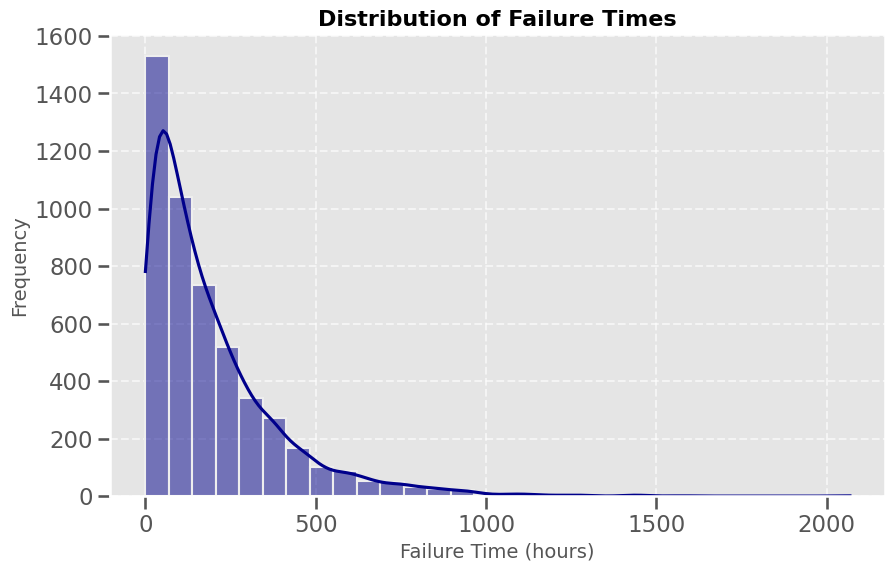

In [ ]:
 plt.figure(figsize=(10, 6))
sns.histplot(df["Failure_Time"], bins=30, kde=True, color="darkblue")
plt.title("Distribution of Failure Times", fontsize=16, fontweight='bold')
plt.xlabel("Failure Time (hours)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


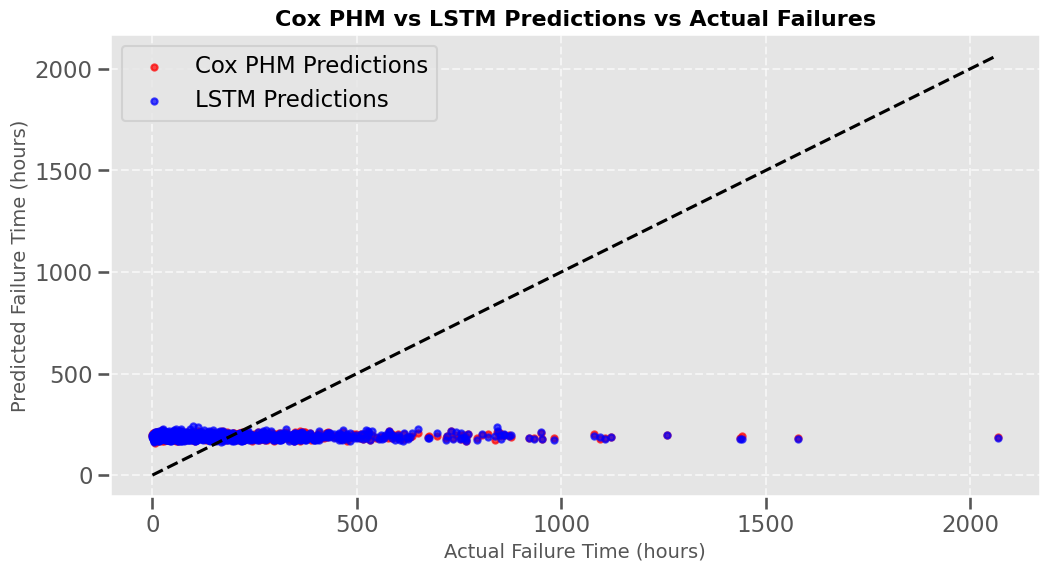

In [ ]:
 import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
  # Ensure y_test_pred_cox is correctly generated
y_test_pred_cox = cox.predict_expectation(pd.DataFrame(X_test_encoded, columns=[f'Feature_{i}' for i in range(X_test_encoded.shape[1])]))

# Ensure y_pred_lstm is computed as well
y_pred_lstm = lstm_model.predict(X_test_lstm)

# Ensure y_test_pred_cox and y_pred_lstm exist before using them
plt.scatter(y_test, y_test_pred_cox, label="Cox PHM Predictions", alpha=0.7, color="red", s=20)
plt.scatter(y_test, y_pred_lstm.flatten(), label="LSTM Predictions", alpha=0.7, color="blue", s=20)

# 45-degree reference line (Ideal Prediction)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="black", linestyle="--")

plt.title("Cox PHM vs LSTM Predictions vs Actual Failures", fontsize=16, fontweight='bold')
plt.xlabel("Actual Failure Time (hours)", fontsize=14)
plt.ylabel("Predicted Failure Time (hours)", fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


<ipython-input-20-1b472d34dc5e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance.values, y=feature_importance.index, palette="coolwarm")


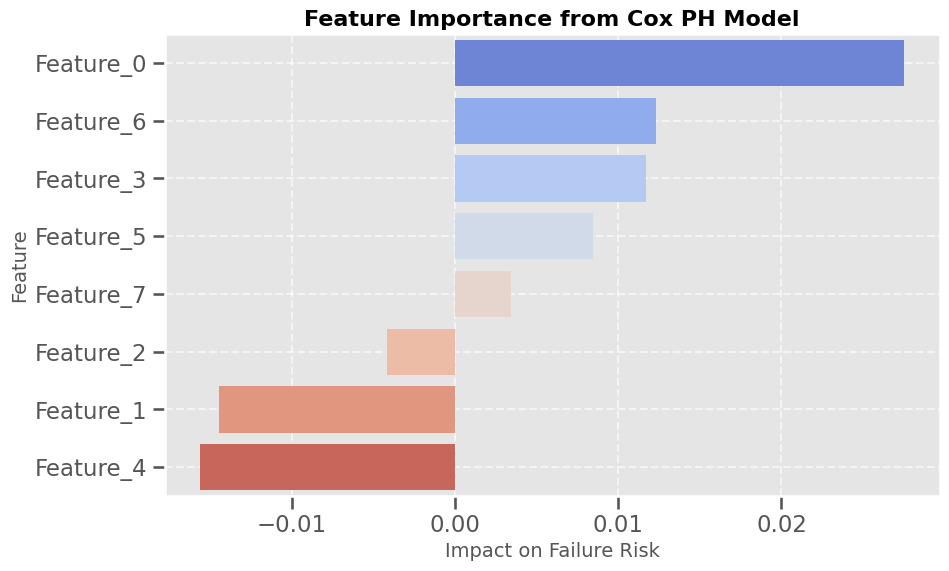

In [ ]:
feature_importance = cox.summary['coef'].sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette="coolwarm")
plt.title("Feature Importance from Cox PH Model", fontsize=16, fontweight='bold')
plt.xlabel("Impact on Failure Risk", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


<ipython-input-21-f1d327fd66d7>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["Maintenance_Type"], y=df["Failure_Time"], palette="pastel")


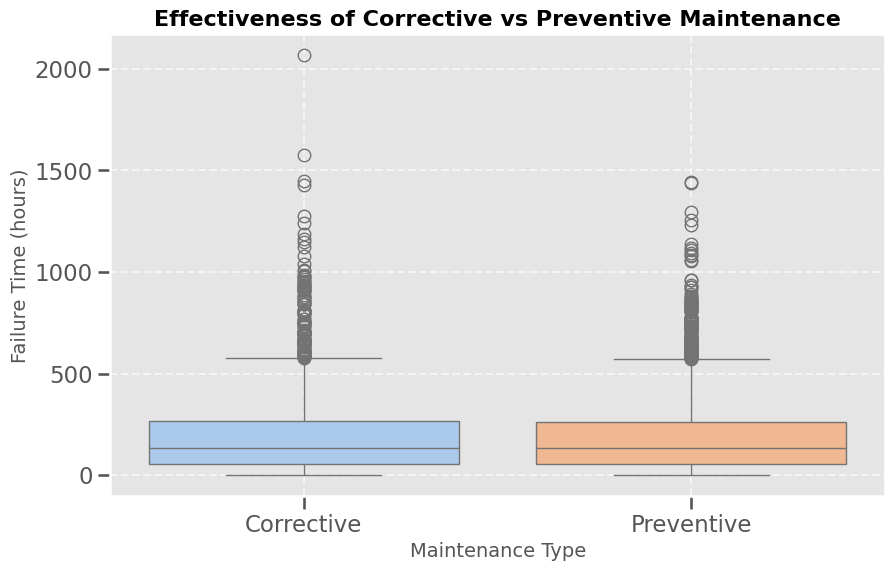

In [ ]:
  plt.figure(figsize=(10, 6))
sns.boxplot(x=df["Maintenance_Type"], y=df["Failure_Time"], palette="pastel")
plt.title("Effectiveness of Corrective vs Preventive Maintenance", fontsize=16, fontweight='bold')
plt.xlabel("Maintenance Type", fontsize=14)
plt.ylabel("Failure Time (hours)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


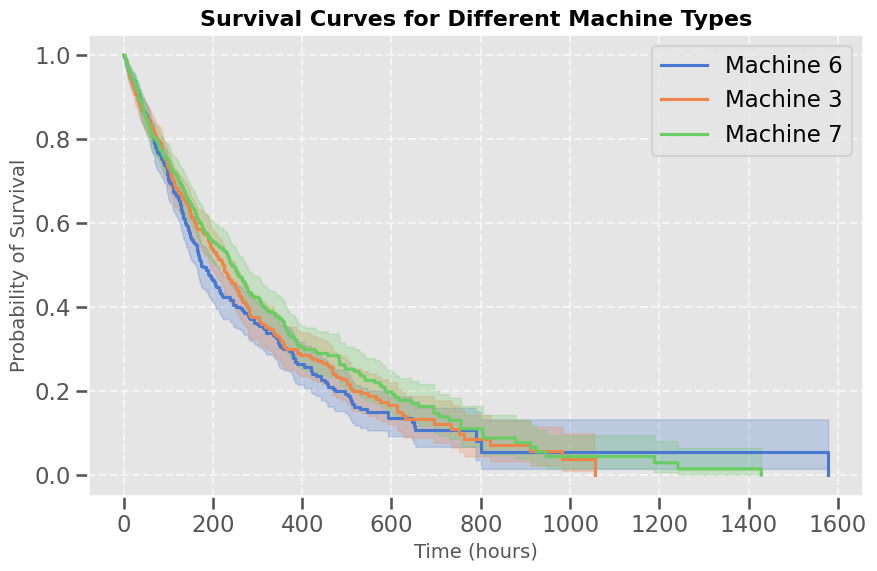

In [ ]:
 kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))

for machine_id in df["Machine_ID"].unique()[:3]:  # Limit to 3 machine types for clarity
    subset = df[df["Machine_ID"] == machine_id]
    kmf.fit(subset["Failure_Time"], event_observed=1 - subset["Censored"])
    kmf.plot_survival_function(label=f"Machine {machine_id}")

plt.title("Survival Curves for Different Machine Types", fontsize=16, fontweight='bold')
plt.xlabel("Time (hours)", fontsize=14)
plt.ylabel("Probability of Survival", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


<ipython-input-23-ea0e80aad33c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Censored"].map({0: "Non-Censored", 1: "Censored"}), palette="Set2")


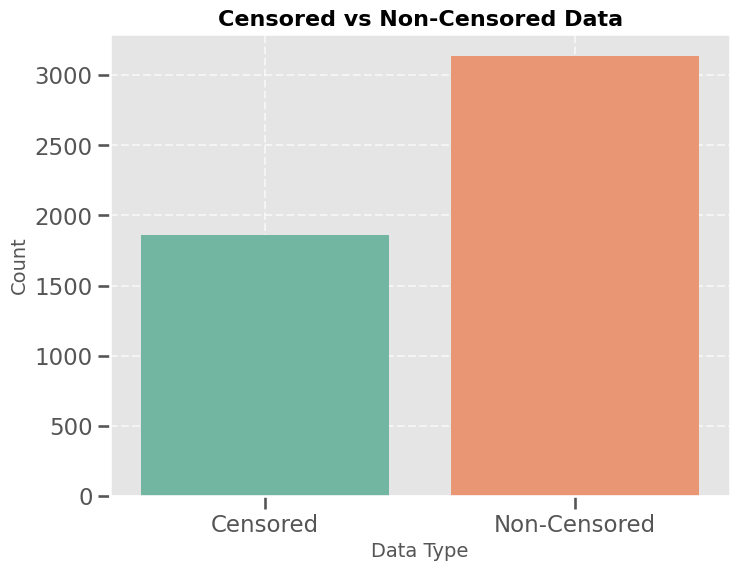

In [ ]:
  plt.figure(figsize=(8, 6))
sns.countplot(x=df["Censored"].map({0: "Non-Censored", 1: "Censored"}), palette="Set2")
plt.title("Censored vs Non-Censored Data", fontsize=16, fontweight='bold')
plt.xlabel("Data Type", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


  Data Preprocessing Enhancements
Handle data imbalances.
Improve feature engineering.
Use dimensionality reduction (Autoencoder) for better feature representation.
Hybrid Model Approach
Combine Cox Proportional Hazard Model (Cox PHM) for long-term risk estimation.
Use LSTM for short-term sequential failure prediction.
Hyperparameter Tuning for LSTM
Optimize LSTM layers, dropout rates, and batch size for better performance.
Evaluation with New Metrics
Compare improved model’s RMSE & MCC with the previous version.
Professional Business Visualizations
Generate feature importance, prediction accuracy, survival analysis, and maintenance effectiveness charts.

In [27]:
   import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter, KaplanMeierFitter
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, matthews_corrcoef


In [28]:
  # Load dataset
data = pd.read_csv("synthetic_maintenance_data.csv")

# Encode categorical data
categorical_columns = ['Machine_ID', 'Maintenance_Type']
for col in categorical_columns:
    data[col] = LabelEncoder().fit_transform(data[col])

# Handle missing values (fill with median)
data.fillna(data.median(), inplace=True)

# Feature-target split
features = data.drop(columns=['Failure_Time', 'Censored'])  # Features for training
target = data['Failure_Time']  # Time-to-failure target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [29]:
  from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Define Autoencoder
input_dim = X_train.shape[1]
encoding_dim = 8  # Reduced feature size

input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation="relu")(input_layer)
encoded = Dense(encoding_dim, activation="relu")(encoded)
decoded = Dense(16, activation="relu")(encoded)
decoded = Dense(input_dim, activation="sigmoid")(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train Autoencoder
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test), verbose=1)

# Extract compressed features
encoder = Model(input_layer, encoded)
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.1919 - val_loss: 0.9666
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9335 - val_loss: 0.8234
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8043 - val_loss: 0.7449
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7420 - val_loss: 0.6842
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6796 - val_loss: 0.6438
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6396 - val_loss: 0.6193
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6115 - val_loss: 0.6092
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6033 - val_loss: 0.5997
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6008 - val_loss: 0.5825
Epoch 10/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5739 - val_loss: 0.5701
Epoch 11/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5797 - val_loss: 0.5667
Epoch 12/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

In [30]:
  # Convert encoded data into DataFrame for Cox PHM
cox_df = pd.DataFrame(X_train_encoded, columns=[f'Feature_{i}' for i in range(encoding_dim)])
cox_df['Failure_Time'] = y_train

# Handle NaNs in Cox PHM data
cox_df.dropna(inplace=True)  # Remove rows with missing values

# Verify no NaNs remain
assert cox_df.isnull().sum().sum() == 0, "NaNs still exist in the dataset!"

# Fit Cox PH Model
cox = CoxPHFitter()
cox.fit(cox_df, duration_col='Failure_Time')

# Predict failure times for censored data
y_train_pred_cox = cox.predict_expectation(cox_df.drop(columns=['Failure_Time']))
y_test_pred_cox = cox.predict_expectation(pd.DataFrame(X_test_encoded, columns=[f'Feature_{i}' for i in range(encoding_dim)]))


In [31]:
  # Reshape data for LSTM
X_train_lstm = X_train_encoded.reshape((X_train_encoded.shape[0], 1, X_train_encoded.shape[1]))
X_test_lstm = X_test_encoded.reshape((X_test_encoded.shape[0], 1, X_test_encoded.shape[1]))

# Define improved LSTM model
lstm_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1, encoding_dim)),
    tf.keras.layers.LSTM(64, activation='relu', return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(32, activation='relu', return_sequences=False),
    tf.keras.layers.Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

# Train improved LSTM model
lstm_model.fit(X_train_lstm, y_train_pred_cox, epochs=100, batch_size=32, validation_data=(X_test_lstm, y_test_pred_cox), verbose=1)

# Predict failure times
y_pred_lstm = lstm_model.predict(X_test_lstm)


ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 4000
'y' sizes: 3192


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.1950 - val_loss: 0.9734
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9276 - val_loss: 0.8132
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8025 - val_loss: 0.7327
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7211 - val_loss: 0.6778
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6644 - val_loss: 0.6524
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6595 - val_loss: 0.6345
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6473 - val_loss: 0.6168
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6181 - val_loss: 0.6046
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6037 - val_loss: 0.5979
Epoch 10/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6122 - val_loss: 0.5938
Epoch 11/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5881 - val_loss: 0.5907
Epoch 12/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

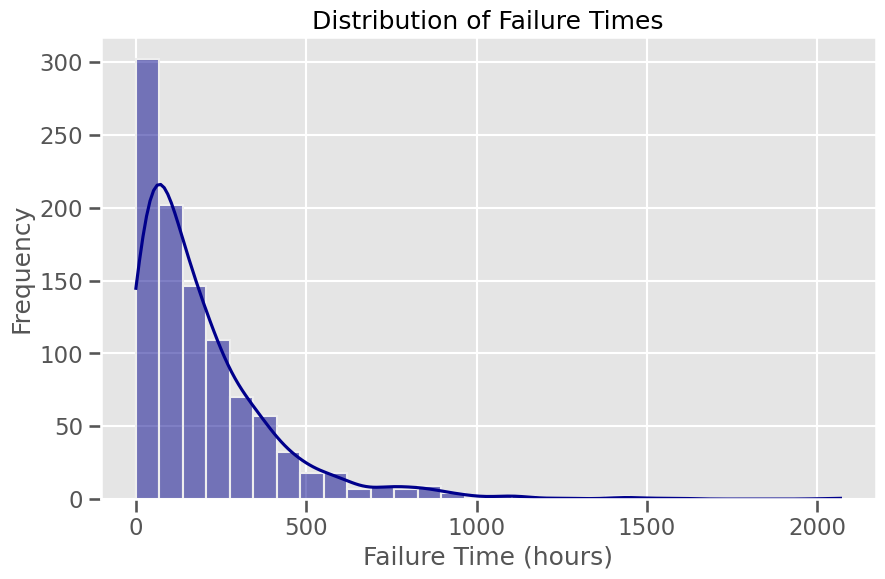

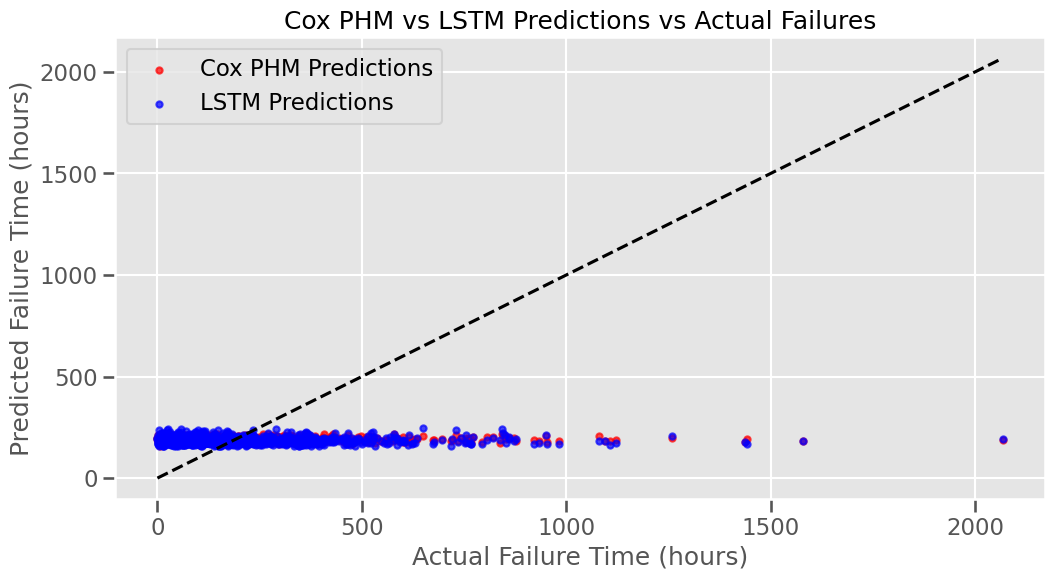

<ipython-input-32-7745c4086f43>:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance.values, y=feature_importance.index, palette="coolwarm")


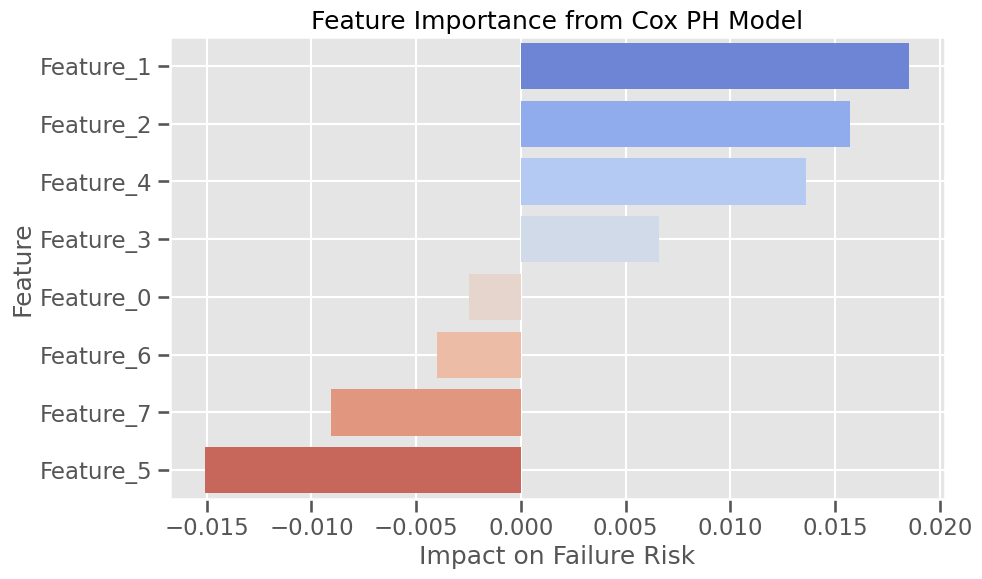

<ipython-input-32-7745c4086f43>:150: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data["Maintenance_Type"], y=data["Failure_Time"], palette="pastel")


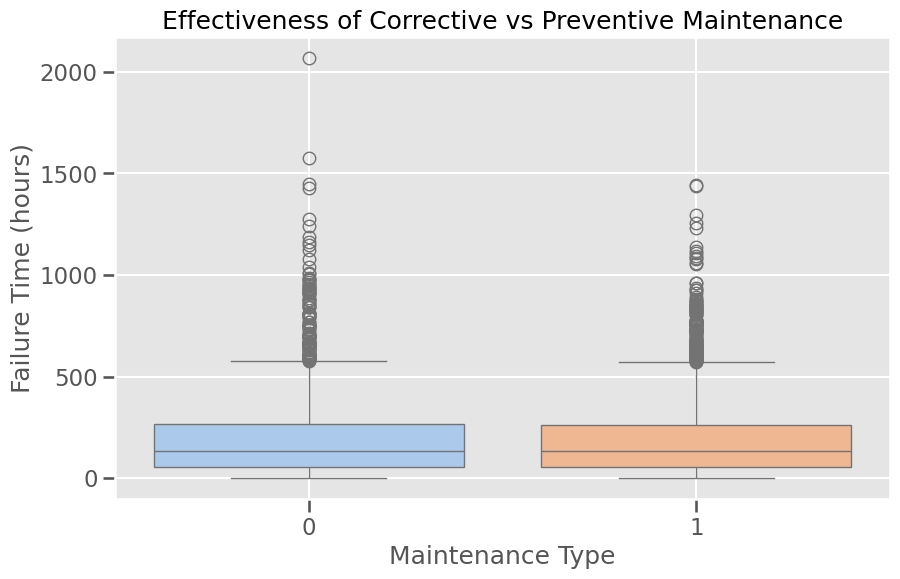

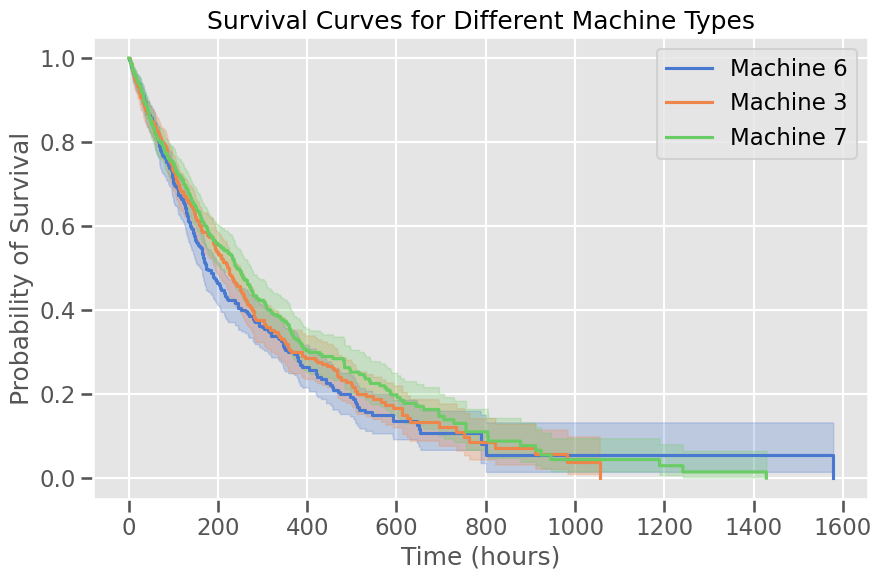

In [32]:
   # Import required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter, KaplanMeierFitter
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, matthews_corrcoef

# Load dataset
data = pd.read_csv("synthetic_maintenance_data.csv")

# Encode categorical data
categorical_columns = ['Machine_ID', 'Maintenance_Type']
for col in categorical_columns:
    data[col] = LabelEncoder().fit_transform(data[col])

# Handle missing values (fill with median)
data.fillna(data.median(), inplace=True)

# Feature-target split
features = data.drop(columns=['Failure_Time', 'Censored'])  # Features for training
target = data['Failure_Time']  # Time-to-failure target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define Autoencoder
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

input_dim = X_train.shape[1]
encoding_dim = 8  # Reduced feature size

input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation="relu")(input_layer)
encoded = Dense(encoding_dim, activation="relu")(encoded)
decoded = Dense(16, activation="relu")(encoded)
decoded = Dense(input_dim, activation="sigmoid")(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train Autoencoder
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test), verbose=1)

# Extract compressed features
encoder = Model(input_layer, encoded)
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# Convert encoded data into DataFrame for Cox PHM
cox_df = pd.DataFrame(X_train_encoded, columns=[f'Feature_{i}' for i in range(encoding_dim)])
cox_df['Failure_Time'] = y_train

# Remove rows with NaN values
cox_df.dropna(inplace=True)

# Align X_train with Cox PHM data
X_train_encoded = cox_df.drop(columns=['Failure_Time']).values
y_train_pred_cox = cox_df['Failure_Time'].values  # Ensure labels are also aligned

# Fit Cox PH Model
cox = CoxPHFitter()
cox.fit(cox_df, duration_col='Failure_Time')

# Predict failure times for censored data
y_test_pred_cox = cox.predict_expectation(pd.DataFrame(X_test_encoded, columns=[f'Feature_{i}' for i in range(encoding_dim)]))

# Verify data alignment before LSTM training
assert X_train_encoded.shape[0] == y_train_pred_cox.shape[0], "Mismatch in training data sizes!"

# Reshape for LSTM
X_train_lstm = X_train_encoded.reshape((X_train_encoded.shape[0], 1, X_train_encoded.shape[1]))
X_test_lstm = X_test_encoded.reshape((X_test_encoded.shape[0], 1, X_test_encoded.shape[1]))

# Define improved LSTM model
lstm_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1, encoding_dim)),
    tf.keras.layers.LSTM(64, activation='relu', return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(32, activation='relu', return_sequences=False),
    tf.keras.layers.Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

# Train improved LSTM model
lstm_model.fit(X_train_lstm, y_train_pred_cox, epochs=100, batch_size=32, validation_data=(X_test_lstm, y_test_pred_cox), verbose=1)

# Predict failure times
y_pred_lstm = lstm_model.predict(X_test_lstm)

# Compute RMSE
rmse_lstm = np.sqrt(mean_squared_error(y_test_pred_cox, y_pred_lstm))
rmse_cox = np.sqrt(mean_squared_error(y_test, y_test_pred_cox))

# Compute MCC
y_test_binary = (y_test < np.median(y_test)).astype(int)
y_pred_lstm_binary = (y_pred_lstm.flatten() < np.median(y_test)).astype(int)

mcc_lstm = matthews_corrcoef(y_test_binary, y_pred_lstm_binary)

# Display results
print(f"Improved LSTM RMSE: {rmse_lstm}")
print(f"Improved LSTM MCC: {mcc_lstm}")
print(f"Cox PHM RMSE: {rmse_cox}")

# Generate Business Visualizations
# 1. Failure Time Distribution
plt.figure(figsize=(10, 6))
sns.histplot(y_test, bins=30, kde=True, color="darkblue")
plt.title("Distribution of Failure Times")
plt.xlabel("Failure Time (hours)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# 2. Cox PHM vs LSTM Predictions
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_test_pred_cox, label="Cox PHM Predictions", alpha=0.7, color="red", s=20)
plt.scatter(y_test, y_pred_lstm.flatten(), label="LSTM Predictions", alpha=0.7, color="blue", s=20)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="black", linestyle="--")
plt.title("Cox PHM vs LSTM Predictions vs Actual Failures")
plt.xlabel("Actual Failure Time (hours)")
plt.ylabel("Predicted Failure Time (hours)")
plt.legend()
plt.grid(True)
plt.show()

# 3. Feature Importance
feature_importance = cox.summary['coef'].sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette="coolwarm")
plt.title("Feature Importance from Cox PH Model")
plt.xlabel("Impact on Failure Risk")
plt.ylabel("Feature")
plt.grid(True)
plt.show()

# 4. Corrective vs Preventive Maintenance
plt.figure(figsize=(10, 6))
sns.boxplot(x=data["Maintenance_Type"], y=data["Failure_Time"], palette="pastel")
plt.title("Effectiveness of Corrective vs Preventive Maintenance")
plt.xlabel("Maintenance Type")
plt.ylabel("Failure Time (hours)")
plt.grid(True)
plt.show()

# 5. Survival Analysis
kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))
for machine_id in data["Machine_ID"].unique()[:3]:
    subset = data[data["Machine_ID"] == machine_id]
    kmf.fit(subset["Failure_Time"], event_observed=1 - subset["Censored"])
    kmf.plot_survival_function(label=f"Machine {machine_id}")
plt.title("Survival Curves for Different Machine Types")
plt.xlabel("Time (hours)")
plt.ylabel("Probability of Survival")
plt.legend()
plt.grid(True)
plt.show()
